In [87]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections.abc import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib.pyplot import figure, show
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing




review = pd.read_json('Project_1/yelp_academic_dataset_review.json', lines=True, nrows = 1000000)
business = pd.read_json('Project_1/yelp_academic_dataset_business.json', lines=True, nrows = 1000000)

# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})  
    if sort:
        t.sort_values(by=['y'], inplace=True)
    
    plt.figure(figsize=(10, 6))
    a = plt.plot(t['y'].tolist(), label='expected')
    b = plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.xlim(0, 300)
    plt.ylim(0, 60)

    plt.show() 

"def chart_regression(pred, y, sort=True):\n    t = pd.DataFrame({'pred': pred.flatten(), 'y': y.to_numpy()})\n    if sort:\n        t.sort_values(by=['y'], inplace=True)\n    \n    plt.figure(figsize=(10, 6))\n    plt.plot(t['y'].tolist(), label='Expected', color='blue', marker='o', linestyle='-')\n    plt.plot(t['pred'].tolist(), label='Prediction', color='orange', marker='x', linestyle='--')\n    \n    plt.title('Regression Prediction vs True Values')\n    plt.xlabel('Sample Index')\n    plt.ylabel('Rating')\n    plt.legend()\n    plt.grid()\n    plt.show()"

In [2]:
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [3]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [4]:
business.shape

(150346, 14)

In [5]:
review.shape

(1000000, 9)

In [6]:
business = business[business['review_count'] >= 20] #Removing all the businesses with less than 20 reviews

In [7]:
business.shape

(61919, 14)

In [8]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."


In [9]:
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [10]:
review = review.groupby('business_id')['text'].sum()

In [11]:
review

business_id
--ZVrH2X2QXBFdCilbirsw    This place is sadly perm closed. I was hoping ...
--_9CAxgfXZmoFdNIRrhHA    It's a huge place. There's P.O. boxes big enou...
--_lZuj_WCGnDG6n0emlRg    Good deals to be had on liquidated designer cl...
--hF_3v1JmU9nlu4zfXJ8Q    Really excited to get healthier options on the...
--sXnWH9Xm6_NvIjyuA99w    Ich war das erste mal in Philadelphia und ich ...
                                                ...                        
zziDpuuJw-Km1J4BaGpBKA    So I'm only rating  on the lunch, they serve. ...
zzjFdJwXuxBOGe9JeY_EMw    Went in for lunch and tried the jerk chicken a...
zznJox6-nmXlGYNWgTDwQQ    Meh, I've definitely been to a better Dunkin' ...
zztOG2cKm87I6Iw_tleZsQ    This course is exactly what I needed to get me...
zzyx5x0Z7xXWWvWnZFuxlQ    Maybe the pizza is good here... but I can real...
Name: text, Length: 27095, dtype: object

In [12]:
review.head()

business_id
--ZVrH2X2QXBFdCilbirsw    This place is sadly perm closed. I was hoping ...
--_9CAxgfXZmoFdNIRrhHA    It's a huge place. There's P.O. boxes big enou...
--_lZuj_WCGnDG6n0emlRg    Good deals to be had on liquidated designer cl...
--hF_3v1JmU9nlu4zfXJ8Q    Really excited to get healthier options on the...
--sXnWH9Xm6_NvIjyuA99w    Ich war das erste mal in Philadelphia und ich ...
Name: text, dtype: object

In [13]:
review_sklearn = pd.DataFrame({'business_id': review.index, 'all_reviews': review.values})

In [14]:
review_sklearn  

,business_id,all_reviews
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...
1,--_9CAxgfXZmoFdNIRrhHA,It's a huge place. There's P.O. boxes big enou...
2,--_lZuj_WCGnDG6n0emlRg,Good deals to be had on liquidated designer cl...
3,--hF_3v1JmU9nlu4zfXJ8Q,Really excited to get healthier options on the...
4,--sXnWH9Xm6_NvIjyuA99w,Ich war das erste mal in Philadelphia und ich ...
...,...,...
27090,zziDpuuJw-Km1J4BaGpBKA,"So I'm only rating on the lunch, they serve. ..."
27091,zzjFdJwXuxBOGe9JeY_EMw,Went in for lunch and tried the jerk chicken a...
27092,zznJox6-nmXlGYNWgTDwQQ,"Meh, I've definitely been to a better Dunkin' ..."
27093,zztOG2cKm87I6Iw_tleZsQ,This course is exactly what I needed to get me...


In [15]:
merged_df = pd.merge(review_sklearn[['business_id', 'all_reviews']], business[['business_id', 'latitude', 'longitude', 'review_count', 'stars', 'name']], on='business_id')
merged_df

,business_id,all_reviews,latitude,longitude,review_count,stars,name
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,39.997299,-75.292207,32,4.5,Chris's Sandwich Shop
1,--sXnWH9Xm6_NvIjyuA99w,Ich war das erste mal in Philadelphia und ich ...,39.952584,-75.165222,29,4.0,Philadelphia
2,-02xFuruu85XmDn2xiynJw,Dr. Curtis Dechant has an excellent chair-side...,32.251039,-110.833173,109,4.5,Family Vision Center
3,-06OYKiIzxsdymBMDAKZug,Had catalytic converters replaced on our Subur...,39.525558,-119.739221,34,4.5,Washoe Metal Fabricating
4,-06ngMH_Ejkm_6HQBYxB7g,I have an old main line that really should be ...,34.419838,-119.688029,25,4.0,Stewart's De Rooting & Plumbing
...,...,...,...,...,...,...,...
11922,zxuVnNVAUm16Sro0dS_lmg,Excellent! Love the location-- fun upscale dec...,39.527851,-119.814337,244,4.0,Roundabout Grill
11923,zzHtFjfM7NvuVM1HTsCLGA,I had the smoked salmon ramen special. The bro...,40.042065,-75.485834,35,4.5,Nom Nom Japanese Kitchen
11924,zzUxvYE-8Fj_dWqsPcagNg,I have been using these guys for two years in ...,32.196817,-110.965636,25,2.0,The Cleaning Authority - Tucson
11925,zzjFdJwXuxBOGe9JeY_EMw,Went in for lunch and tried the jerk chicken a...,40.125572,-75.333395,47,4.0,Taste of the Islands


In [16]:
tfidf = TfidfVectorizer(max_features=3000, stop_words='english', analyzer='word') #Using TF-IDF to do feature extraction from review texts.
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews']) # convert the documents into a matrix

tfidf_tokens = tfidf.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf_tokens)


In [17]:
df_tfidfvect


,00,000,10,100,11,12,13,14,15,16,...,yesterday,yoga,yogurt,york,young,younger,yum,yummy,zero,zucchini
0,0.012967,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.031747,0.000000,0.000000,0.000000
1,0.000000,0.0,0.000000,0.000000,0.000000,0.054720,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.002573,0.016087,0.000000,0.003636,0.0,0.004964,0.015293,0.0,...,0.0,0.0,0.0,0.000000,0.003839,0.0,0.000000,0.000000,0.000000,0.000000
3,0.092272,0.0,0.000000,0.048505,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11922,0.008112,0.0,0.020464,0.006396,0.002173,0.007711,0.0,0.013158,0.029187,0.0,...,0.0,0.0,0.0,0.009441,0.006106,0.0,0.017377,0.018614,0.000000,0.004122
11923,0.000000,0.0,0.007179,0.000000,0.005718,0.005072,0.0,0.000000,0.008533,0.0,...,0.0,0.0,0.0,0.000000,0.005355,0.0,0.000000,0.005442,0.000000,0.000000
11924,0.042584,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.013003,0.000000
11925,0.000000,0.0,0.025889,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.023173,0.0,0.000000,0.023549,0.018802,0.000000


In [18]:
tfidfvect_array = df_tfidfvect.to_numpy() #Convert a Pandas Dataframe to its corresponding Numpy array representation
tfidfvect_array



array([[0.01296732, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0025734 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0425835 , 0.        , 0.        , ..., 0.        , 0.01300321,
        0.        ],
       [0.        , 0.        , 0.02588936, ..., 0.02354877, 0.01880187,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
other_features = merged_df[['latitude', 'longitude', 'review_count']].to_numpy() #additional features



In [20]:
other_features

array([[  39.9972988,  -75.2922074,   32.       ],
       [  39.9525839,  -75.1652215,   29.       ],
       [  32.2510387, -110.8331729,  109.       ],
       ...,
       [  32.196817 , -110.9656358,   25.       ],
       [  40.1255717,  -75.3333947,   47.       ],
       [  27.9900583,  -82.7302255,   30.       ]])

In [21]:
combined_features = np.concatenate((tfidfvect_array, other_features), axis=1)
combined_features

array([[ 1.29673238e-02,  0.00000000e+00,  0.00000000e+00, ...,
         3.99972988e+01, -7.52922074e+01,  3.20000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.99525839e+01, -7.51652215e+01,  2.90000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  2.57339524e-03, ...,
         3.22510387e+01, -1.10833173e+02,  1.09000000e+02],
       ...,
       [ 4.25835001e-02,  0.00000000e+00,  0.00000000e+00, ...,
         3.21968170e+01, -1.10965636e+02,  2.50000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  2.58893594e-02, ...,
         4.01255717e+01, -7.53333947e+01,  4.70000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.79900583e+01, -8.27302255e+01,  3.00000000e+01]])

In [22]:
x = combined_features  # Features 
y = merged_df['stars']  # Target (ratings)

In [23]:
x.shape[1]
y.shape

(11927,)

c:\Users\nisal\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\nisal\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/1000
16/16 - 3s - 193ms/step - loss: 13.6221 - val_loss: 13.2358
Epoch 2/1000
16/16 - 0s - 8ms/step - loss: 12.5692 - val_loss: 11.3328
Epoch 3/1000
16/16 - 0s - 8ms/step - loss: 9.7129 - val_loss: 7.4387
Epoch 4/1000
16/16 - 0s - 8ms/step - loss: 5.7328 - val_loss: 3.7458
Epoch 5/1000
16/16 - 0s - 9ms/step - loss: 3.0405 - val_loss: 2.4026
Epoch 6/1000
16/16 - 0s - 9ms/step - loss: 2.1535 - val_loss: 1.7069
Epoch 7/1000
16/16 - 0s - 8ms/step - loss: 1.5559 - val_loss: 1.3424
Epoch 8/1000
16/16 - 0s - 8ms/step - loss: 1.2748 - val_loss: 1.1540
Epoch 9/1000
16/16 - 0s - 9ms/step - loss: 1.1246 - val_loss: 1.0423
Epoch 10/1000
16/16 - 0s - 9ms/step - loss: 1.0201 - val_loss: 0.9466
Epoch 11/1000
16/16 - 0s - 8ms/step - loss: 0.9442 - val_loss: 0.8924
Epoch 12/1000
16/16 - 0s - 8ms/step - loss: 0.8997 - val_loss: 0.8584
Epoch 13/1000
16/16 - 0s - 9ms/step - loss: 0.8719 - val_loss: 0.8380
Epoch 14/1000
16/16 - 0s - 8ms/step - loss: 0.8534 - val_loss: 0.8249
Epoch 15/1000
16/16 - 0

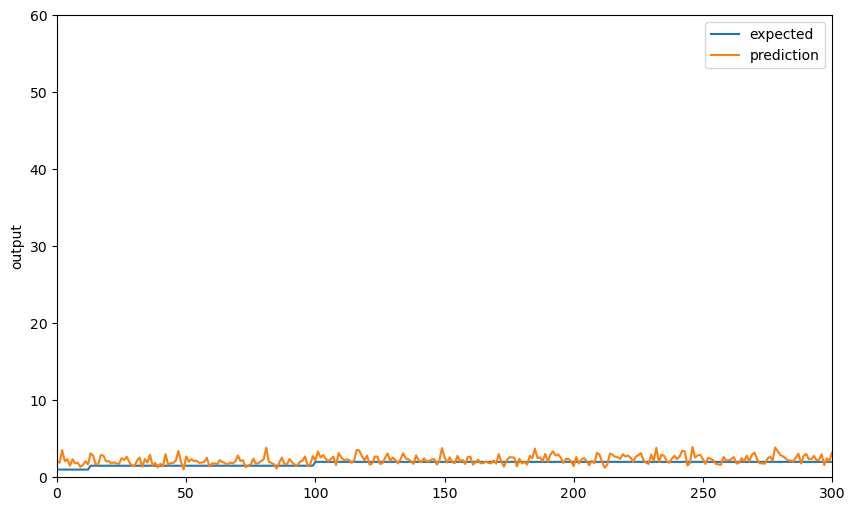

In [88]:
#Activation relu
#Optimizer Adam
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=52)

model = Sequential()

model.add(Dense(15, input_dim=x.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))


adam = optimizers.Adam(learning_rate=0.0001 , beta_1=0.9, beta_2=0.999,  decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adam) #RMSE 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto') #Early stopping
checkpointer = ModelCheckpoint(filepath="project_1/RMSE_1.keras", verbose=0, save_best_only=True) # save best model

model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=500, callbacks=[monitor, checkpointer], verbose=2, epochs=1000)
model.load_weights('project_1/RMSE_1.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
pred = pred.flatten()
y_test = y_test.to_numpy().flatten()
# Plot the chart
chart_regression(pred,y_test)

In [89]:
result_df = pd.DataFrame({
    'Business Name': merged_df['name'].values[:5], # names of the first 5 businesses
    'True Rating': merged_df['stars'].values[:5],   # True ratings
    'Predicted Rating': pred.flatten()[:5]           # Predicted ratings
})
result_df

,Business Name,True Rating,Predicted Rating
0,Chris's Sandwich Shop,4.5,3.788730
1,Philadelphia,4.0,4.344064
2,Family Vision Center,4.5,4.093851
3,Washoe Metal Fabricating,4.5,4.235305
4,Stewart's De Rooting & Plumbing,4.0,3.751950


Epoch 1/1000


c:\Users\nisal\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\nisal\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


78/78 - 1s - 12ms/step - loss: 1.5299 - val_loss: 0.6795
Epoch 2/1000
78/78 - 0s - 3ms/step - loss: 0.7014 - val_loss: 0.6782
Epoch 3/1000
78/78 - 0s - 2ms/step - loss: 0.6992 - val_loss: 0.6814
Epoch 4/1000
78/78 - 0s - 2ms/step - loss: 0.6991 - val_loss: 0.6772
Epoch 5/1000
78/78 - 0s - 2ms/step - loss: 0.6988 - val_loss: 0.6763
Epoch 6/1000
78/78 - 0s - 2ms/step - loss: 0.6970 - val_loss: 0.6764
Epoch 7/1000
78/78 - 0s - 2ms/step - loss: 0.6968 - val_loss: 0.6763
Epoch 8/1000
78/78 - 0s - 2ms/step - loss: 0.6964 - val_loss: 0.6753
Epoch 9/1000
78/78 - 0s - 2ms/step - loss: 0.6956 - val_loss: 0.6772
Epoch 10/1000
78/78 - 0s - 2ms/step - loss: 0.6953 - val_loss: 0.6761
Epoch 10: early stopping
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
Score (RMSE): 0.8217598347843181
<class 'pandas.core.series.Series'>


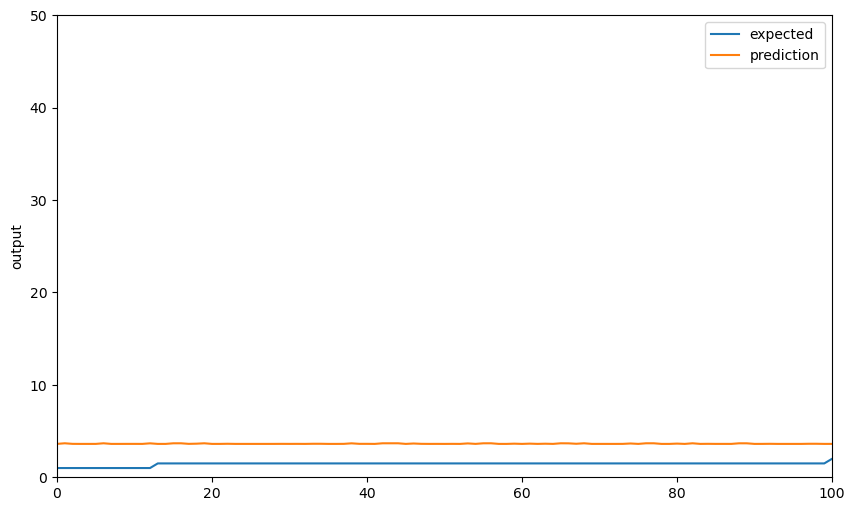

In [75]:
#Activation sigmoid
#Optimizer sgd
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=52)

model = Sequential()

model.add(Dense(15, input_dim=x.shape[1], activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1))


sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd) #sgd 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto') #Early stopping
checkpointer = ModelCheckpoint(filepath="project_1/RMSE_1.keras", verbose=0, save_best_only=True) # save best model

model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=100, callbacks=[monitor, checkpointer], verbose=2, epochs=1000)
model.load_weights('project_1/RMSE_1.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
pred = pred.flatten()
print(type(y_test))
y_test = y_test.to_numpy().flatten()
# Plot the chart
chart_regression(pred.flatten(),y_test)

In [76]:
result_df = pd.DataFrame({
    'Business Name': merged_df['name'].values[:5], # names of the first 5 businesses
    'True Rating': merged_df['stars'].values[:5],   # True ratings
    'Predicted Rating': pred.flatten()[:5]           # Predicted ratings
})
result_df

,Business Name,True Rating,Predicted Rating
0,Chris's Sandwich Shop,4.5,3.635293
1,Philadelphia,4.0,3.679057
2,Family Vision Center,4.5,3.679057
3,Washoe Metal Fabricating,4.5,3.664264
4,Stewart's De Rooting & Plumbing,4.0,3.679057


Epoch 1/2000


c:\Users\nisal\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\nisal\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


280/280 - 2s - 6ms/step - loss: 1.2158 - val_loss: 0.6931
Epoch 2/2000
280/280 - 0s - 1ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/2000
280/280 - 0s - 1ms/step - loss: 0.6940 - val_loss: 0.6928
Epoch 4/2000
280/280 - 0s - 1ms/step - loss: 0.6944 - val_loss: 0.6932
Epoch 4: early stopping
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Score (RMSE): 0.8323430420887314
<class 'pandas.core.series.Series'>


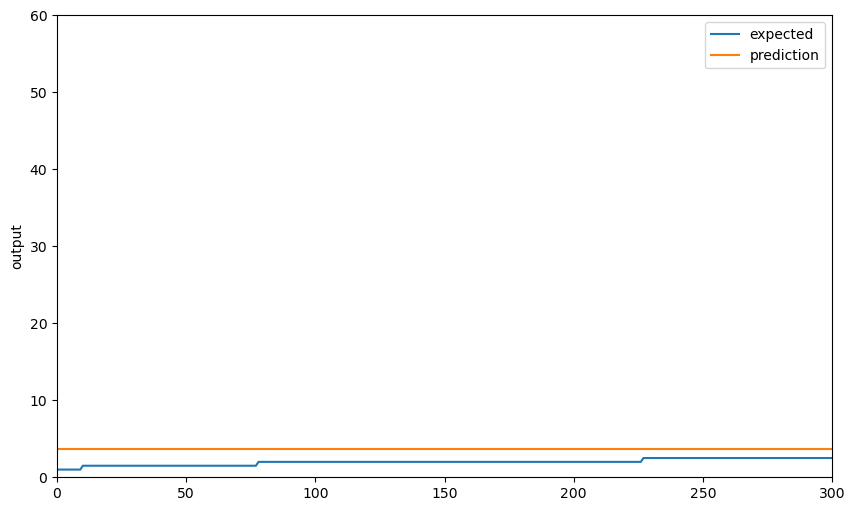

In [90]:
#Activation tanh
#Optimizer adam
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=52)

model = Sequential()

model.add(Dense(15, input_dim=x.shape[1], activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(3, activation='tanh'))
model.add(Dense(1))


Adam = optimizers.Adam(learning_rate=0.005, decay=1e-6 )
model.compile(loss='mean_squared_error', optimizer=Adam) #Adam 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto') #Early stopping
checkpointer = ModelCheckpoint(filepath="project_1/RMSE_1.keras", verbose=0, save_best_only=True) # save best model

model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, callbacks=[monitor, checkpointer], verbose=2, epochs=2000)
model.load_weights('project_1/RMSE_1.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
pred = pred.flatten()
print(type(y_test))
y_test = y_test.to_numpy().flatten()
# Plot the chart
chart_regression(pred.flatten(),y_test)

In [91]:
result_df = pd.DataFrame({
    'Business Name': merged_df['name'].values[:5], # names of the first 5 businesses
    'True Rating': merged_df['stars'].values[:5],   # True ratings
    'Predicted Rating': pred.flatten()[:5]           # Predicted ratings
})
result_df

,Business Name,True Rating,Predicted Rating
0,Chris's Sandwich Shop,4.5,3.608639
1,Philadelphia,4.0,3.608639
2,Family Vision Center,4.5,3.608639
3,Washoe Metal Fabricating,4.5,3.608639
4,Stewart's De Rooting & Plumbing,4.0,3.608639
